# Predict low high models
Model selection for predict lo hi


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
#%pip install binance-connector==1.13.0
%pip install pandas
%pip install scikit-learn
%pip install tensorflow==2.11.0
%pip install keras==2.11.0
%pip install scikeras
%pip install keras-tuner

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

In [2]:
import os
import glob
import pandas as pd
from datetime import timedelta,date

def read_last_data(strategy, days=1, n=None):
    """ Read last last day from bot history """
    
    def read_last(symbol: str, name: str, days=1):
        data_dir=f"./../data/yandex-cloud/{strategy}/Xy"
        file_paths = sorted([f"{data_dir}/{f}" for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-days:]
        print(file_paths)
        return pd.concat([pd.read_csv(f, parse_dates=True, index_col="datetime") for f in file_paths])

    data=read_last("BTCUSDT", "data", days)
    X=read_last("BTCUSDT", "X", days)
    y=read_last("BTCUSDT", "y", days)
    if n: 
        data=data.tail(n)
        X=X.tail(n)
        y=y.tail(n)
    return data,X,y

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"
bidask,X_bot,y_bot = read_last_data(strategy, days=1, n=10000)

['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-22_BTCUSDT_data.csv']
['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-22_BTCUSDT_X.csv']
['./../data/yandex-cloud/LSTMStrategy/Xy/2023-05-22_BTCUSDT_y.csv']


Resample data to use equal time intervals

In [3]:
import re
def get_targets(bidask, predict_window="10s"):
    """ 
    Calculate targets - bid/ask bounds in future prediction window
    """
    fut_min=bidask[["bid", "ask"]][::-1].rolling(predict_window).min()[::-1].rename(columns={"bid":"bid_min_fut", "ask":"ask_min_fut"})
    fut_max=bidask[["bid", "ask"]][::-1].rolling(predict_window).max()[::-1].rename(columns={"bid":"bid_max_fut", "ask":"ask_max_fut"})
    return pd.concat([fut_min, fut_max], axis = 1)
    
def resampled(X: pd.DataFrame, y: pd.DataFrame, time_interval) -> (pd.DataFrame, pd.DataFrame):
    """ Resample to make equal intervals time series """
    if int(re.sub(r'\D', "", time_interval)) == 0:
        return X, y
    Xy=pd.concat([X,y], axis=1)
    diffmap = [(c, "sum") for c in Xy.columns if c.endswith("diff")]
    timemap = [(c, "last") for c in Xy.columns if c.startswith("time") and not c.endswith("diff")]
    l2map = [(c, "last") for c in Xy.columns if c.startswith("l2_")]
    
    futmap = [(c, "last") for c in Xy.columns if c.endswith("_fut")]
    colmap = dict(diffmap + timemap + l2map + futmap + [("spread", "last")])
    resampled = Xy.resample(time_interval).agg(colmap).dropna()
    return resampled[X.columns], resampled[y.columns]

predict_window="10s"
resample_interval="0s"
y_raw = get_targets(bidask, predict_window)
#X,y = resampled(X_bot, y_raw, resample_interval)
X,y=X_bot,y_raw
#pd.concat([X,y], axis=1).dropna()


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
 
def train_test_split(X,y):
    test_size=0.3
    test_index = int(len(X)*(1-test_size))
    X_train, y_train, X_test, y_test = X.iloc[:test_index], y.iloc[:test_index], X.iloc[test_index:], y.iloc[test_index:]


    # Train/test split    
    x_pipe = Pipeline(
        [("xrs", RobustScaler()),
         #("xss", StandardScaler()),     
         ("xmms", MinMaxScaler())])
    x_pipe.fit(X_train)

    y_pipe = Pipeline(
        [("yrs", RobustScaler()),
         #("yss",StandardScaler()),     
         ("ymms",MinMaxScaler())])
    y_pipe.fit(y_train)

    #x_scaler, y_scaler = MinMaxScaler().fit(X_train), MinMaxScaler().fit(y_train)
    X_train, y_train = x_pipe.transform(X_train), y_pipe.transform(y_train)
    X_test, y_test = x_pipe.transform(X_test), y_pipe.transform(y_test)
    print(f"Train size: {X_train.shape[0]}, test size: {X_test.shape[0]}")
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X, y)
print(X_train.shape)

Train size: 7000, test size: 3000
(7000, 80)


## Model tuning


In [40]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import *
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner




def create_tuner_model(hp):
    """ Create model for tuner. Expects X_train, y_train, window_size"""
    model = Sequential()
#     model.add(LSTM(128,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(Dropout(0.2))
    hp_input_units=hp.Int("input_units", min_value=600, max_value=1200, step=200)
    #hp_window_size=hp.Int("window_size", min_value=10, max_value=110, step=20)
    model.add(LSTM(hp_input_units,
                   return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(LSTM(600,
#                    return_sequences=True, input_shape=(window_size, X_train.shape[1])), name="lstm_input")
    model.add(Dropout(0.2))
    
    hp_lstm_main=hp.Int("lstm_main_units", min_value=32, max_value=1000, step=100)
    model.add(LSTM(hp_lstm_main))         
    model.add(Dropout(0.2))

    hp_dense_main=hp.Int("dense_main_units", min_value=4, max_value=100, step=20)
    model.add(Dense(hp_dense_main, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(y_train.shape[1], activation='linear'))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model
    
window_size = 10

def create_tuner():
    # Tune the model
    # tuner=keras_tuner.Hyperband(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_epochs=5,
    #     factor=3,
    #     hyperband_iterations=1,
    #     seed=None,
    #     hyperparameters=None,
    #     tune_new_entries=True,
    #     allow_new_entries=True,
    #     max_retries_per_trial=0,
    #     max_consecutive_failed_trials=3
    # )
    tuner=keras_tuner.BayesianOptimization(
        hypermodel=create_tuner_model,
        objective="val_mse",
        max_trials=10,
        num_initial_points=None,
        alpha=0.0001,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        overwrite=True,
        directory=f"./tmp/{strategy}/tune",
        project_name="biml",    
    )
    # tuner = keras_tuner.RandomSearch(
    #     hypermodel=create_tuner_model,
    #     objective="val_mse",
    #     max_trials=3,
    #     executions_per_trial=2,
    #     overwrite=True,
    #     directory=f"./tmp/{strategy}/tune",
    #     project_name="biml",
    #     )
    tuner.search_space_summary()
    return tuner

def tuner_search(train_gen, test_gen):
    tuner = create_tuner()
    tuner.search(train_gen,epochs=5, validation_data=test_gen)
    return tuner

train_gen = TimeseriesGenerator(X_train, y_train, length=window_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=window_size)
tuner = tuner_search(train_gen, test_gen)





Trial 10 Complete [00h 00m 58s]
val_mse: 0.04486250877380371

Best val_mse So Far: 0.04486250877380371
Total elapsed time: 00h 09m 52s
INFO:tensorflow:Oracle triggered exit


In [42]:
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")

tuner.results_summary()
models=tuner.get_best_models(5)
for model in models:
    model.summary()



Results summary
Results in ./tmp/LSTMStrategy/tune/biml
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 09 summary
Hyperparameters:
input_units: 1200
lstm_main_units: 132
dense_main_units: 44
Score: 0.04486250877380371

Trial 02 summary
Hyperparameters:
input_units: 1200
lstm_main_units: 132
dense_main_units: 44
Score: 0.0448678582906723

Trial 00 summary
Hyperparameters:
input_units: 800
lstm_main_units: 732
dense_main_units: 84
Score: 0.04486947879195213

Trial 08 summary
Hyperparameters:
input_units: 800
lstm_main_units: 832
dense_main_units: 64
Score: 0.04489416256546974

Trial 03 summary
Hyperparameters:
input_units: 1000
lstm_main_units: 832
dense_main_units: 4
Score: 0.04490943253040314

Trial 05 summary
Hyperparameters:
input_units: 1200
lstm_main_units: 432
dense_main_units: 24
Score: 0.04491284862160683

Trial 01 summary
Hyperparameters:
input_units: 1000
lstm_main_units: 632
dense_main_units: 64
Score: 0.04491288214921951

Trial 07 summary
Hyperparam

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 1200)          6148800   
                                                                 
 dropout (Dropout)           (None, 10, 1200)          0         
                                                                 
 lstm_1 (LSTM)               (None, 132)               703824    
                                                                 
 dropout_1 (Dropout)         (None, 132)               0         
                                                                 
 dense (Dense)               (None, 44)                5852      
                                                                 
 dropout_2 (Dropout)         (None, 44)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

 lstm (LSTM)                 (None, 10, 800)           2819200   
                                                                 
 dropout (Dropout)           (None, 10, 800)           0         
                                                                 
 lstm_1 (LSTM)               (None, 832)               5434624   
                                                                 
 dropout_1 (Dropout)         (None, 832)               0         
                                                                 
 dense (Dense)               (None, 64)                53312     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 8,307,396
Trainable params: 8,307,396
Non-trainable params: 0


Epoch 1/20
5/5 [==============================] - 3s 190ms/step - loss: 0.3083 - mse: 0.1544 - val_loss: 0.1475 - val_mse: 0.0322
Epoch 2/20
5/5 [==============================] - 0s 58ms/step - loss: 0.1592 - mse: 0.0386 - val_loss: 0.1473 - val_mse: 0.0332
Epoch 3/20
5/5 [==============================] - 0s 60ms/step - loss: 0.1403 - mse: 0.0303 - val_loss: 0.1565 - val_mse: 0.0362
Epoch 4/20
5/5 [==============================] - 0s 60ms/step - loss: 0.1209 - mse: 0.0278 - val_loss: 0.1341 - val_mse: 0.0274
Epoch 5/20
5/5 [==============================] - 0s 58ms/step - loss: 0.1133 - mse: 0.0217 - val_loss: 0.1319 - val_mse: 0.0256
Epoch 6/20
5/5 [==============================] - 0s 59ms/step - loss: 0.1866 - mse: 0.0571 - val_loss: 0.1482 - val_mse: 0.0305
Epoch 7/20
5/5 [==============================] - 0s 58ms/step - loss: 0.2306 - mse: 0.0803 - val_loss: 0.1442 - val_mse: 0.0288
Epoch 8/20
5/5 [==============================] - 0s 59ms/step - loss: 0.2837 - mse: 0.1357 - va

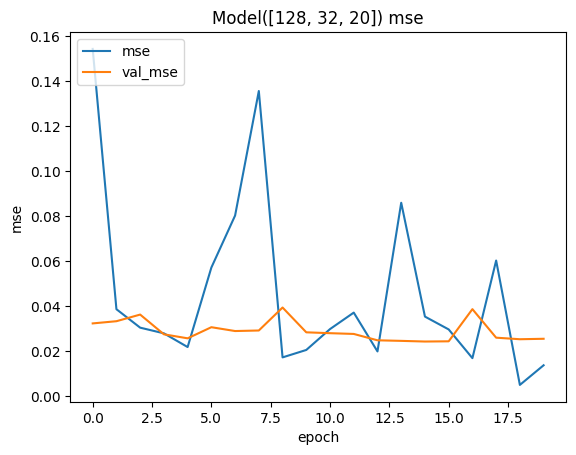

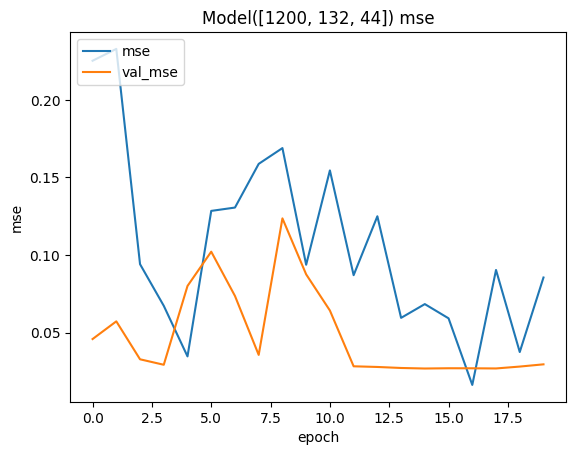

In [79]:
# def create_model_prod(X_train, y_train, window_size):
#     model = Sequential()
#     model.add(LSTM(128,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32))         
#     model.add(Dropout(0.2))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(y_train.shape[1], activation='linear'))
#     #model.add(Dense(y_train.shape[1], activation='softmax'))
#     model.compile(optimizer='adam', loss='mae', metrics=['mse'])
#     return model  

def create_model(X_train, y_train, window_size, input_units, lstm_main_units, dense_main_units):
    # 1200, 132, 44
    # 800, 800, 64
    model = Sequential()
    model.add(LSTM(input_units,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_main_units))         
    model.add(Dropout(0.2))
    model.add(Dense(dense_main_units, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='linear')) # linear for regression
    #model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model


def plot_history(model_name, history, metric=None):
    """ Plot history loss and metrics"""
    metric_names = [metric] if metric else history.history
    
    # Print all merrics
    for metric_name in metric_names:
        # Validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        names=[metric_name, f"val_{metric_name}"]
        for name in names:
            plt.plot(history.history[name])
        # Captions and show the plot
        plt.title(f"{model_name} {metric_name}")
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(names, loc='upper left')
        plt.show()

def fit_model(model, train_gen, test_gen):
    # Fit the model
    epochs=20
    steps_per_epoch=5
    history=model.fit(train_gen, validation_data=test_gen, epochs=epochs, steps_per_epoch=steps_per_epoch)
    return history
    # Plot the result
    #plot_history(history)    
   
def evaluate_model(input_units, lstm_units, dense_units):
    model = create_model(X_train, y_train, window_size, input_units, lstm_units, dense_units)
    history = fit_model(model, train_gen, test_gen)
    model_name = f"Model({input_units},{lstm_units},{dense_units})"
    plot_history(model_name, history)

def evaluate_models(*inputs):
    results={}
    for unit_spec in inputs:
        model = create_model(X_train, y_train, window_size, unit_spec[0], unit_spec[1], unit_spec[2])
        history = fit_model(model, train_gen, test_gen)
        model_name = f"Model({unit_spec})"
        results[model_name] = history
    for model_name in results:
        plot_history(model_name, results[model_name], "mse")

    
# Good: 80, 512, 20
#evaluate_model(80,512,20)        
evaluate_models([128,32,20], [1200,132,44])
#evaluate_model(80,800,20)        
#evaluate_model(128,32,20)    
#evaluate_model(1200,132,44)    
